---
title: Telecom Equipment Detection with Azure Custom Vision (Free) - Part 2  
author: "Francisco Mussari"  
date: 2022-10-15  
image: "/blog-pictures/Part-2-Image.PNG"  
categories: [computer-vision, deeplearning, azure, custom-vision, object-detection]  
format:
  html:
    toc: true
    toc-depth: 3
    
---

Part 2. Label images with Smart Labeler

![](./blog-pictures/Part-2.PNG)

## Introduction

In this series of posts we are going to follow along the process and code required to train an *object detection* model using [Azure Custom Vision](https://azure.microsoft.com/en-us/pricing/details/cognitive-services/custom-vision-service) (in its free tier). 

-> We are going to use real world pictures compiled from work I have done over the years in Venezuela. In this kind of *supervised learning* problem we need tagged images. So we will use [Smart Labeler](https://learn.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/suggested-tags) to do that.

After the model is published in Azure service, we can use the API to build and share a demo with [Gradio](https://gradio.app/) and [Huggingface](https://huggingface.co/).

Here is the one that is already published for you to try:  
[Telecom-Object-Detection](https://huggingface.co/spaces/fmussari/Telecom-Object-Detection)

#### The model will be trained to detect the following objects:
- Grid Antenna
- Panel antenna
- Radome antenna
- RRU
- Shroud antenna
- Solid antenna

<table>
    <tr>
        <td> <img src="blog-pictures/Grid.jpg"  alt="1" width = 200px height = 200px ></td>
        <td><img src="blog-pictures/Panel.jpg" alt="2" width = 200px height = 200px></td>
        <td><img src="blog-pictures/Radome.jpg" alt="2" width = 200px height = 200px></td>
    </tr>
    <tr>
        <td>Grid</td><td>Panel</td><td>Radome</td>
    </tr>
    <tr>
        <td> <img src="blog-pictures/RRU.jpg"  alt="1" width = 200px height = 200px ></td>
        <td> <img src="blog-pictures/Shroud.jpg"  alt="1" width = 200px height = 200px ></td>
        <td> <img src="blog-pictures/Solid.jpg"  alt="1" width = 200px height = 200px ></td>
    </tr>
    <tr>
        <td>RRU</td><td>Shroud</td><td>Solid</td>
    </tr>
</table>

## Tutorial Parts

- Part 1 covered:
    - Creating a [free](https://azure.microsoft.com/en-us/pricing/details/cognitive-services/custom-vision-service/#pricing) Azure [Custom Vision](https://www.customvision.ai/) Service.
    - Uploading the images to the service.
  
- **Part 2 will cover**:
    - Analyzing what happens to the images after uploading.
    - How to label the images using [Smart Labeler](https://learn.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/suggested-tags)
    - Training and publishing the model.
   
- Part 3 will cover:
    - Create a Huggingface Gradio Demo.

## References

- Custom Vision Documentation: [Label images faster with Smart Labeler](https://learn.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/suggested-tags)
- Microsoft Learn Excersice: [Detect Objects in Images with Custom Vision](https://microsoftlearning.github.io/AI-102-AIEngineer/Instructions/18-object-detection.html)
- Custom Vision Documentation: [Quickstart: Create an object detection project with the Custom Vision client library](https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/quickstarts/object-detection?tabs=visual-studio&pivots=programming-language-python)
- REST API Endpoint: [Custom Vision REST API reference - Azure Cognitive Services](https://docs.microsoft.com/en-us/rest/api/custom-vision/)
- APIs Documentation: [Custom_Vision_Training_3.3](https://southcentralus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Training_3.3)
- Azure SDK for Python: [Custom Vision Client Library](https://learn.microsoft.com/en-us/python/api/overview/azure/cognitiveservices-vision-customvision-readme?view=azure-python)
- Source Code: [Azure/azure-sdk-for-python](https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/cognitiveservices/azure-cognitiveservices-vision-customvision/azure/cognitiveservices/vision/customvision/training/operations/_custom_vision_training_client_operations.py)

## Part 2.1. Labeling the Images

**Smart Labeler** is a simple tool for labeling images. It can be used for classification and object detection problems. When working in this problem I missed the ability to zoom-in when labeling some small objects, but as I said, this is a straightforward tool.    
  
For speeding up bigger projects it might be usefull that you can first label some pictures, then train and get suggestions for the untagged images, but I didn't use it. By default the labeler tries to give suggestions even without that first training.  

The process is simple and you can the use the annotation to train models outside the service (as we are going to try after this series, hopefully, using fastai).

### Install and import libraries

We need to install Custom Vision's Python SDK and python-dotenv:  
`! pip install azure-cognitiveservices-vision-customvision==3.1.0`  
`! pip install python-dotenv`

In [ ]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region, ImageRegionCreateEntry
from msrest.authentication import ApiKeyCredentials
import time
import json
import os

import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pathlib import Path

from PIL import Image, ImageOps
from PIL import UnidentifiedImageError

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

### Credentials and services
- [`ApiKeyCredentials`](https://learn.microsoft.com/en-us/python/api/msrest/msrest.authentication.apikeycredentials?view=azure-python)
- [`CustomVisionTrainingClient`](https://learn.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-customvision/azure.cognitiveservices.vision.customvision.training.customvisiontrainingclient?view=azure-python)
- [`CustomVisionTrainingClient.get_project()`](https://learn.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-customvision/azure.cognitiveservices.vision.customvision.training.operations.customvisiontrainingclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-customvision-training-operations-customvisiontrainingclientoperationsmixin-get-project)

In [ ]:
DOTENV_PATH = './.env'

In [ ]:
#| echo: false
DOTENV_PATH = './creds/.env'

In [ ]:
load_dotenv(DOTENV_PATH)
training_endpoint = os.getenv('TrainingEndpoint')
training_key = os.getenv('TrainingKey')
project_id = os.getenv('ProjectID')

credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
training_client = CustomVisionTrainingClient(training_endpoint, credentials)
custom_vision_project = training_client.get_project(project_id)

### Creating Labels

Since I already did the manual tagging, we can use those tags in this new project.  
First we need to create the labels/tags in the service: 
- [`CustomVisionTrainingClient.create_tag()`](https://learn.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-customvision/azure.cognitiveservices.vision.customvision.training.operations.customvisiontrainingclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-customvision-training-operations-customvisiontrainingclientoperationsmixin-create-tag)

In [ ]:
tags = ['Grid', 'Panel', 'Radome', 'RRU', 'Shroud', 'Solid']
desc = ['Grid Antenna', 'Panel Cel. Antenna', 'Radome Antenna', 
        'RRU Equipment', 'Shroud Antenna', 'Solid Antenna']

In [ ]:
service_tags = []
for i, tag in enumerate(tags):
    service_tags.append(
        training_client.create_tag(
            project_id=project_id, name=tag,
            description=desc[i]
        )
    )
service_tags

[<azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag>,
 <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag>,
 <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag>,
 <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag>,
 <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag>,
 <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag>]

Now we can see this in the service:  
![](./blog-pictures/Part-2-Tags.PNG)

In [ ]:
service_tag_ids = {tag.name: tag.id for tag in service_tags}
service_tag_ids

{'Grid': 'e016b6a4-49e6-4897-a0c7-d8fc64d032f1',
 'Panel': 'c9b15b62-6823-44a4-8fee-fa9d84e65a7e',
 'Radome': 'a1020654-79c5-4d8a-867c-93dfb2a4a81d',
 'RRU': '91ffb5b0-fe25-4d72-9c65-14793183a3b9',
 'Shroud': '4e413c15-141a-419b-a958-1485008b2904',
 'Solid': '3f13d9b0-7b4d-4679-8fb8-7855cea0a118'}

In [ ]:
#| echo: false
#| output: false
created_regions = pd.read_csv('20220922_203_Image_1279_Regions.csv')
created_regions.columns = ['old_image_id', 'left', 'top', 'width', 'height', 'old_tag_name']
created_regions.head(5)

,old_image_id,left,top,width,height,old_tag_name
0,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.639558,0.000000,0.107401,0.147763,rru
1,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.772766,0.160598,0.226649,0.406335,panel
2,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.661631,0.000000,0.097804,0.070547,rru
3,96431dba-ec76-43aa-b16a-8ea8f02fd0fe,0.138905,0.355230,0.066597,0.081269,panel
4,96431dba-ec76-43aa-b16a-8ea8f02fd0fe,0.316626,0.227232,0.068994,0.059279,shrout


In [ ]:
#| echo: false
#| output: false
old_ids_names = pd.read_csv('20220819_374_Images_UpLoaded_WxH.csv')

old_ids_names_map = {_id: _name for _id, _name in zip(old_ids_names.image_id, old_ids_names.image_name)}

In [ ]:
#| echo: false
#| output: false
created_regions['image_name'] = created_regions.old_image_id.map(old_ids_names_map)
created_regions.head(5)

,old_image_id,left,top,width,height,old_tag_name,image_name
0,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.639558,0.000000,0.107401,0.147763,rru,torre cerro el pavon 087.jpg
1,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.772766,0.160598,0.226649,0.406335,panel,torre cerro el pavon 087.jpg
2,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.661631,0.000000,0.097804,0.070547,rru,torre cerro el pavon 087.jpg
3,96431dba-ec76-43aa-b16a-8ea8f02fd0fe,0.138905,0.355230,0.066597,0.081269,panel,torre cerro el pavon 086.jpg
4,96431dba-ec76-43aa-b16a-8ea8f02fd0fe,0.316626,0.227232,0.068994,0.059279,shrout,torre cerro el pavon 086.jpg


In [ ]:
#| echo: false
#| output: false
new_ids = pd.read_csv('20221015_203_Images_Uploaded_WxH.csv')

new_names_ids_map = {_name: _id for _name, _id in zip(new_ids.image_name, new_ids.image_id)}
#new_names_ids_map

In [ ]:
#| echo: false
#| output: false

created_regions['image_id'] = created_regions.image_name.map(new_names_ids_map)
created_regions

,old_image_id,left,top,width,height,old_tag_name,image_name,image_id
0,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.639558,0.000000,0.107401,0.147763,rru,torre cerro el pavon 087.jpg,6e274dfc-411a-4bf3-9151-51b96f662248
1,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.772766,0.160598,0.226649,0.406335,panel,torre cerro el pavon 087.jpg,6e274dfc-411a-4bf3-9151-51b96f662248
2,361f72b5-db0a-4aa7-bcef-a5b3101125f9,0.661631,0.000000,0.097804,0.070547,rru,torre cerro el pavon 087.jpg,6e274dfc-411a-4bf3-9151-51b96f662248
3,96431dba-ec76-43aa-b16a-8ea8f02fd0fe,0.138905,0.355230,0.066597,0.081269,panel,torre cerro el pavon 086.jpg,ea34cbad-8d50-4b5f-aed0-91d7fe40a754
4,96431dba-ec76-43aa-b16a-8ea8f02fd0fe,0.316626,0.227232,0.068994,0.059279,shrout,torre cerro el pavon 086.jpg,ea34cbad-8d50-4b5f-aed0-91d7fe40a754
...,...,...,...,...,...,...,...,...
1274,30a118e7-54f4-4890-8a03-6ee6dad30fd1,0.645532,0.098880,0.023936,0.021912,panel,CIMG0031.JPG,3027bc7e-6e21-4b13-a7d7-bb7e08ce6824
1275,30a118e7-54f4-4890-8a03-6ee6dad30fd1,0.675532,0.114936,0.023936,0.021912,panel,CIMG0031.JPG,3027bc7e-6e21-4b13-a7d7-bb7e08ce6824
1276,0609181b-f5c1-4b3e-bec0-52e74472be49,0.374030,0.107219,0.033065,0.041772,shrout,CIMG0030.JPG,96b7774e-f5ad-4591-aa71-99ad5c71135e
1277,3d8d9528-ff25-432d-b3e4-bc850d364ed4,0.389685,0.551581,0.175667,0.177576,mesh,41.JPG,452a0b58-0dc5-41ff-83d1-8d1ae7bd5d1c


In [ ]:
#| echo: false
#| output: false

regions = []

old_tag_name = {
    'mesh': 'Grid', 'panel': 'Panel', 
    'radome': 'Radome', 'rru': 'RRU', 
    'shrout': 'Shroud', 'solid': 'Solid'
}

for idx, row in created_regions.iterrows():
    regions.append({
        'imageId': row.image_id,
        'tagId': service_tag_ids[old_tag_name[row.old_tag_name]],
        'left': row.left, 'top': row.top,
        'width': row.width, 'height': row.height
    })
    
print(len(regions))
body = {'regions': regions}

with open("20221016_CreateImageRegions_Body.json", "w") as outfile:
    json.dump(body, outfile)

1279


### Upload Regions from json file
As I pointed before, you can create all the regions with Smart Labeler. Since I did that already in a previos project, I updated the region's image ids and tags to the ones in this project and save them as a json.  

- [`CustomVisionTrainingClient.create_image_regions()`](https://learn.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-customvision/azure.cognitiveservices.vision.customvision.training.operations.customvisiontrainingclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-customvision-training-operations-customvisiontrainingclientoperationsmixin-create-image-regions)

We can see from the documentation that "There is a limit of 64 entries in a batch."

In [ ]:
with open("20221016_CreateImageRegions_Body.json") as json_file:
    regions_dict = json.load(json_file)

print(f'We have a total of {len(regions_dict["regions"]):_} regions.')
print()
print('The first two regions:')
regions_dict['regions'][:2]

We have a total of 1_279 regions.

The first two regions:


[{'imageId': '6e274dfc-411a-4bf3-9151-51b96f662248',
  'tagId': '91ffb5b0-fe25-4d72-9c65-14793183a3b9',
  'left': 0.6395582,
  'top': 0,
  'width': 0.10740108,
  'height': 0.14776269},
 {'imageId': '6e274dfc-411a-4bf3-9151-51b96f662248',
  'tagId': 'c9b15b62-6823-44a4-8fee-fa9d84e65a7e',
  'left': 0.772766,
  'top': 0.16059849,
  'width': 0.22664931,
  'height': 0.40633526}]

In [ ]:
# Create batches of 60 regions

regions = regions_dict['regions']

for i in range(int(1_279 / 60)+1):
    
    batch_regions = []
    print(f'Creating Regions {i*60+1:>{5}_} to {min((i+1)*60, 1_279):>{5}_}')
    
    for region in regions[i*60: (i+1)*60]:
        batch_regions.append(
            ImageRegionCreateEntry(
                image_id=region['imageId'],
                tag_id=region['tagId'],
                left=region['left'], top=region['top'],
                width=region['width'], height=region['height']
        ))

    training_client.create_image_regions(
        project_id=project_id, 
        regions=batch_regions
    )

Creating Regions     1 to    60
Creating Regions    61 to   120
Creating Regions   121 to   180
Creating Regions   181 to   240
Creating Regions   241 to   300
Creating Regions   301 to   360
Creating Regions   361 to   420
Creating Regions   421 to   480
Creating Regions   481 to   540
Creating Regions   541 to   600
Creating Regions   601 to   660
Creating Regions   661 to   720
Creating Regions   721 to   780
Creating Regions   781 to   840
Creating Regions   841 to   900
Creating Regions   901 to   960
Creating Regions   961 to 1_020
Creating Regions 1_021 to 1_080
Creating Regions 1_081 to 1_140
Creating Regions 1_141 to 1_200
Creating Regions 1_201 to 1_260
Creating Regions 1_261 to 1_279


Example image, capture from the service:  
![](./blog-pictures/Part-2-Regions.PNG)

### Verifying the number of created Regions

In [ ]:
all_tagged_images = training_client.get_images(
    project_id=project_id,
    tagging_status="Tagged", 
    take=250   # Max 256
)
i = 0
for im in all_tagged_images: i += len(im.regions)
print(f"Number of created Regions: {i:_}")

Number of created Regions: 1_279


### Draw some regions

In [ ]:
images_df = pd.read_csv('20221015_203_Images_Uploaded_WxH.csv')
images_df.index = images_df.image_id
images_df.head(5)

,image_name,image_id,image_status,ori_w,ori_h,train_w,train_h
image_id,,,,,,,
452a0b58-0dc5-41ff-83d1-8d1ae7bd5d1c,41.JPG,452a0b58-0dc5-41ff-83d1-8d1ae7bd5d1c,OK,640,480,640,480
96b7774e-f5ad-4591-aa71-99ad5c71135e,CIMG0030.JPG,96b7774e-f5ad-4591-aa71-99ad5c71135e,OK,1620,2160,900,1200
3027bc7e-6e21-4b13-a7d7-bb7e08ce6824,CIMG0031.JPG,3027bc7e-6e21-4b13-a7d7-bb7e08ce6824,OK,1620,2160,900,1200
1320ab2e-3405-4853-bd7e-b0ef0f915d4b,CIMG0056.JPG,1320ab2e-3405-4853-bd7e-b0ef0f915d4b,OK,2160,1620,1200,900
aa67eceb-3db0-4026-bf16-0842c006e6ac,CIMG0059.JPG,aa67eceb-3db0-4026-bf16-0842c006e6ac,OK,2160,1620,1200,900


Create a dictionary to easily access all regions from an image id:

In [ ]:
img2ann = dict()

for image in all_tagged_images:
    img2ann[image.id] = tuple([list(), list()])
    image_w = image.width; image_h = image.height
    ori_w = images_df.loc[image.id].ori_w
    ori_h = images_df.loc[image.id].ori_h
    for region in image.regions:
        img2ann[image.id][1].append(region.tag_name)
        img2ann[image.id][0].append([
            region.left*ori_w, 
            region.top*ori_h, 
            region.width*ori_w, 
            region.height*ori_h
        ])

In [ ]:
pics_folder = Path('./train_images')

In [ ]:
# https://youtu.be/Z0ssNAbe81M?t=4636
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()
    ])

def draw_rect(ax, b):
    patch = ax.add_patch(
        patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=1)
    )
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
def draw_regions(index=0):
    im = Image.open( pics_folder / images_df.iloc[index].image_name )
    ax = show_img(im, figsize=(8,8))

    reg, lab = img2ann[images_df.iloc[index].image_id]
    for idx, region in enumerate(reg):
        draw_rect(ax, np.array(region))
        tag = lab[idx]
        draw_text(ax, region[:2], tag)

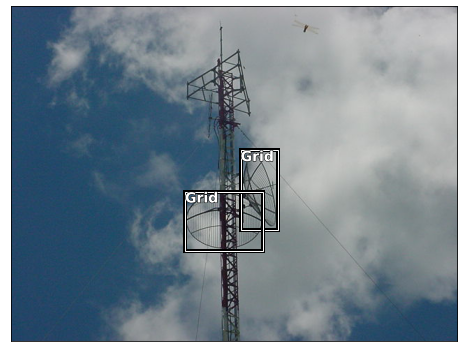

In [ ]:
draw_regions(index=0)

A dragon-fly was cought in that picture!

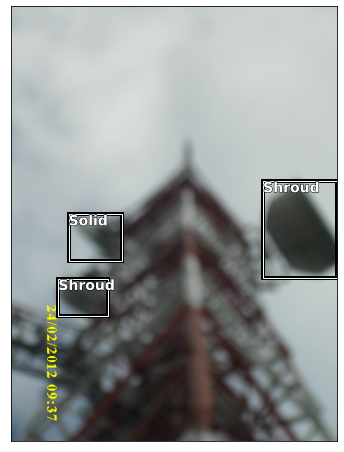

In [ ]:
draw_regions(index=100)

## Part 2.2. Train and Test a Model

### Train the model

- [`CustomVisionTrainingClient.train_project()`](https://learn.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-customvision/azure.cognitiveservices.vision.customvision.training.operations.customvisiontrainingclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-customvision-training-operations-customvisiontrainingclientoperationsmixin-train-project)

In [ ]:
train_iteration = training_client.train_project(
    project_id=project_id,
    training_type='Regular'
)

In [ ]:
train_iteration.as_dict()

{'id': 'd0006e20-33dd-4806-9fe9-cfc3fca82552',
 'name': 'Iteration 1',
 'status': 'Training',
 'created': '2022-10-12T13:34:38.120Z',
 'last_modified': '2022-10-22T14:56:30.406Z',
 'project_id': 'f6cb4ba7-5bbe-46a4-8836-69654dc86f3a',
 'exportable': False,
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 0}

- [`CustomVisionTrainingClient.get_iteration_performance()`](https://learn.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-customvision/azure.cognitiveservices.vision.customvision.training.operations.customvisiontrainingclientoperationsmixin?view=azure-python#azure-cognitiveservices-vision-customvision-training-operations-customvisiontrainingclientoperationsmixin-get-iteration-performance)

In [ ]:
performance = training_client.get_iteration_performance(
    project_id=project_id,
    iteration_id=train_iteration.id
).as_dict()

   
for tag in performance['per_tag_performance']:
    print('/'*20)
    print('tag:', tag['name'])
    print('image count:', training_client.get_tag(
        project_id=project_id, tag_id=service_tags[tag['name']]
    ).image_count)
    print('recall:', tag['recall'])
    print('average_precision:', tag['average_precision'])

////////////////////
tag: Shroud
image count: 140
recall: 0.35789475
average_precision: 0.7280897
////////////////////
tag: Panel
image count: 68
recall: 0.11392405
average_precision: 0.3710658
////////////////////
tag: Solid
image count: 88
recall: 0.21428572
average_precision: 0.4641156
////////////////////
tag: Grid
image count: 80
recall: 0.10526316
average_precision: 0.3784035
////////////////////
tag: Radome
image count: 20
recall: 0.0
average_precision: 0.051538005
////////////////////
tag: RRU
image count: 32
recall: 0.13043478
average_precision: 0.48053658


Some things that I would take into account now that negatively impact the model performance:
- I choose many images with small boxes.
- Some tags are not represented equally, so we ended an unbalanced distribution.
- And of course lets remember we only did a quick train.  


Here is my tweet about this blog post:

<center>

<blockquote class="twitter-tweet">

<p lang="en" dir="ltr">

I started a new blog to write content in English.<br>The first post is 'Creating a blog with Quarto in 10 steps'<a href="https://twitter.com/quarto_pub?ref_src=twsrc%5Etfw">@quarto_pub</a> <br><br>In this post, I introduce you to my new blog and show how you can create a blog with Quarto:<a href="https://t.co/u9Umh3X5eu">https://t.co/u9Umh3X5eu</a><a href="https://twitter.com/hashtag/rstats?src=hash&amp;ref_src=twsrc%5Etfw">#rstats</a> <a href="https://twitter.com/hashtag/rladies?src=hash&amp;ref_src=twsrc%5Etfw">#rladies</a> feedback is welcome!

</p>

If you want a very good thread on some tips and tricks for object detection:  
  
  
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">😨 Training an Object Detection Model is a very challenging task and involves tweaking so many knobs<br><br>Here is an exhaustive 🎁 tips &amp; tricks list 🎁 that you could use to boost your model performance <br><br>🧵 <a href="https://t.co/sOvEUhCCwg">pic.twitter.com/sOvEUhCCwg</a></p>&mdash; AI Fast Track (@ai_fast_track) <a href="https://twitter.com/ai_fast_track/status/1583125709685673985?ref_src=twsrc%5Etfw">October 20, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

### Test the model

In [ ]:
service_tags = {
    'Grid': 'e016b6a4-49e6-4897-a0c7-d8fc64d032f1',
    'Panel': 'c9b15b62-6823-44a4-8fee-fa9d84e65a7e',
    'Radome': 'a1020654-79c5-4d8a-867c-93dfb2a4a81d',
    'RRU': '91ffb5b0-fe25-4d72-9c65-14793183a3b9',
    'Shroud': '4e413c15-141a-419b-a958-1485008b2904',
    'Solid': '3f13d9b0-7b4d-4679-8fb8-7855cea0a118'
}

## Conslusions
